In [1]:
%load_ext autoreload
%autoreload 2
import torch
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from EarlyStopping import EarlyStopping
from models.OpenGraphCon import OpenGraph
from experiment import setup_model
from open_dataset import load_dataset, load_folds
from torch_geometric.nn.models import GCN
from evaluation import eval_validation_model, eval_test_model
from models.DGI import DeepGraphInfomax, corrupt, readout
from pathlib import Path
from utils import calc_avg_dicts
from torch_geometric.loader import NeighborLoader
from models.OpenGCN import OpenGCN
import matplotlib.patches as mpatches


In [2]:
device = torch.device(*('cuda', 0) if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
def setup_model(data, device, model_name, log_all, pseudo_label_method):
    hidden_channels = 64
    num_layers = 2
    dropout = 0.8
    if model_name == "pown":
        encoder = GCN(in_channels = -1,
                        hidden_channels = hidden_channels,
                        out_channels = None,
                        dropout = dropout,
                        num_layers = num_layers)
            
            
            
        dgi = DeepGraphInfomax(hidden_channels = hidden_channels, 
                               encoder = encoder,
                               summary = readout,
                               corruption = corrupt)
    
        #random.seed(0)
        #np.random.seed(0)
        #torch.manual_seed(0)
            
        model = OpenGraph(dgi, hidden_channels,
                             data.classes.size(0), data.known_classes, data.unknown_classes, device, 
                             sup_loss_weight = 0.863386,
                             pseudo_loss_weight = 0.308698,
                             unsup_loss_weight = 0.461507,
                             entropy_loss_weight = 0.101025,
                             geometric_loss_weight = 0.21989507112302817,
                             ood_percentile = 0.882899,
                             proto_type="param",
                             log_all = False,
                             pseudo_label_method = pseudo_label_method)
    else:
    
        model =  OpenGCN(in_channels = data.x.shape[1], 
                          hidden_channels = hidden_channels,
                          out_dim =  data.classes.size(0),
                          dropout = dropout, 
                          num_layers = num_layers, 
                          known_classes = data.known_classes, 
                          unknown_classes = data.unknown_classes, 
                          device = device,
                          log_all = log_all)
    return model
    return og_model

In [4]:
def train_model(og_model, optimizer, data, dataset_name, device, log_all):
    
    og_model = og_model.to(device)   

    model_path = Path("model_backup/model_"+dataset_name+"_"+str(7)+"_backup_simpletest.pth")
    es = EarlyStopping(patience=50, path=Path(model_path))
    
    og_model.train()
    
    for epoch in tqdm(range(1)):
        og_model.train()
            
        data = data.to(device)
        loss = og_model.train_one_epoch(optimizer, data)

        #log data
        if log_all:
            og_model.eval()
            data = data.to(device)
            pred = og_model.inference(data.x, data.edge_index)
            known_val_acc, unknown_val_acc, all_val_acc, val_unseen_mi, known_val_acc_mt = eval_validation_model(pred,
                                                                                               data.y,
                                                                                                data.known_class_val_mask, 
                                                                                               data.unknown_class_val_mask, 
                                                                                               data.all_class_val_mask, 
                                                                                               device)


            if es(all_val_acc, og_model):
                og_model.load_state_dict(torch.load(model_path))
                break

    data = data.to(device)       
    og_model.post_train_processing(data)

    return og_model

In [5]:
def train_model_with_sampler(og_model, optimizer, data, dataset_name, device, log_all):
    
    og_model = og_model.to(device)   

    model_path = Path("model_backup/model_"+dataset_name+"_"+str(7)+"_backup_test.pth")
    es = EarlyStopping(patience=50, path=Path(model_path))
    
    og_model.train()
    
    for epoch in tqdm(range(500)):
        
        og_model.train()
        og_model = og_model.to(device)
        og_model.device = device
        data = data.to(device)

        nl = NeighborLoader(data, 
                            num_neighbors=[128, 32], 
                            num_workers=4, 
                            batch_size=4096,
                            directed = True,
                            pin_memory=True)
        
        

        for data_sampled in nl:
            loss = og_model.train_one_epoch(optimizer, data_sampled)

        
        #log data
        if log_all:
            og_model.eval()
            cpu_device = torch.device('cpu')
            data = data.to(cpu_device)
            og_model = og_model.to(cpu_device)
            og_model.device = cpu_device
            
            pred = og_model.inference(data.x, data.edge_index)
            known_val_acc, unknown_val_acc, all_val_acc, val_unseen_mi, known_val_acc_mt = eval_validation_model(pred,
                                                                                               data.y,
                                                                                               data.known_class_val_mask, 
                                                                                               data.unknown_class_val_mask, 
                                                                                               data.all_class_val_mask, 
                                                                                               device)


            if es(all_val_acc, og_model):
                og_model.load_state_dict(torch.load(model_path))
                break

    cpu_device = torch.device('cpu')
    data = data.to(cpu_device)
    og_model = og_model.everything_to_device(cpu_device)
    og_model.post_train_processing(data)
    og_model = og_model.everything_to_device(device)


    return og_model

In [6]:
def perform_one_run(fold_id, seed, data, dataset_name, model_name, device):
    
    og_model = setup_model(data, device, model_name, log_all=False, pseudo_label_method="lp")
    optimizer = torch.optim.Adam(og_model.parameters(), 
                                         lr=0.001, 
                                         weight_decay = 0.0)

    
    og_model = og_model.to(device)
    data = data.to(device)
    
    start_weights = og_model.get_edge_weights(data)
        
    og_model = train_model(og_model, optimizer, data, dataset_name, device, log_all=True)

    end_weights = og_model.get_edge_weights(data)

    og_model.eval()
    cpu_device = torch.device('cpu')
    data = data.to(cpu_device)
    og_model = og_model.to(cpu_device)
    og_model.device = cpu_device
    
    pred = og_model.inference(data.x, data.edge_index)
    known_val_acc, unknown_val_acc, all_val_acc, val_unseen_mi, known_val_acc_mt = eval_validation_model(pred,
                                                                                       data.y,
                                                                                       data.known_class_val_mask, 
                                                                                       data.unknown_class_val_mask, 
                                                                                       data.all_class_val_mask, 
                                                                                       device)
    known_test_acc, unknown_test_acc, all_test_acc, test_unseen_mi, known_test_acc_mt = eval_test_model(pred, 
                                                                                             data.y, 
                                                                                             data.known_class_test_mask, 
                                                                                             data.unknown_class_test_mask, 
                                                                                             data.all_class_test_mask,
                                                                                             device)

    
    #embeddings = og_model.get_embeddings(data.x, data.edge_index)
    #path = Path("embeddings/embeddings_pown_photo.pth")
    #torch.save(embeddings, path)

    result_run_dict = {
        "fold_id" : fold_id,
        "seed" : seed,
        "data" : data.detach().cpu(),
        "start_weights" : start_weights.detach().cpu(),
        "end_weights" : end_weights.detach().cpu(),
        "known_val_acc_run" : known_val_acc,
        "unknown_val_acc_run" : unknown_val_acc,
        "all_val_acc_run" : all_val_acc,
        "val_unseen_mi_run" : val_unseen_mi,
        "known_test_acc_run": known_test_acc,
        "unknown_test_acc_run": unknown_test_acc,
        "all_test_acc_run" : all_test_acc,
        "test_unseen_mi_run" : test_unseen_mi
    }
    return result_run_dict

In [7]:
def run_setup(num_repeats, pseudo_label_method, dataset_name, model_name):
    
    datasets = load_folds(dataset_name, unknown_class_ratio=0.2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #device = torch.device('cpu')
  
    result_dicts = []

    for seed in range(num_repeats):
        
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        
        for fold_id, data in enumerate(datasets):
    
            result_run_dict = perform_one_run(fold_id, seed, data, dataset_name, model_name, device)
                
            result_dicts.append(result_run_dict)
            
    return result_dicts #calc_avg_dicts(result_dicts, blacklist=['seed', 'fold_id'])

In [8]:
def analyse_edge_weights(result_dict):
    data = result_dict["data"]
    
    start_weights = result_dict["start_weights"]
    end_weights = result_dict["end_weights"]

    homophilic_edges = data.y[data.edge_index[0]] == data.y[data.edge_index[1]]
    heterophilic_edges = ~homophilic_edges

    common_norm=False
    sns.kdeplot(data=start_weights[homophilic_edges], label="Homohilic before", common_norm=common_norm, linestyle="--", color="C0")
    sns.kdeplot(data=start_weights[heterophilic_edges], label="Heterohilic before", common_norm=common_norm, linestyle="--", color="C1")
    
    sns.kdeplot(data=end_weights[homophilic_edges], label="Homohilic after", common_norm=common_norm, color="C0")
    sns.kdeplot(data=end_weights[heterophilic_edges], label="Heterohilic after", common_norm=common_norm, color="C1")

    start_diff = start_weights[homophilic_edges].mean()-start_weights[heterophilic_edges].mean()
    end_diff = end_weights[homophilic_edges].mean()-end_weights[heterophilic_edges].mean()
    gain = end_diff - start_diff
    gain_label = "Gain: " + str(gain)
    print("Start diff: ", start_diff)
    print("End diff: ", end_diff)
    print("Gain: ", gain)

    means = [start_weights[homophilic_edges].mean().numpy(), start_weights[heterophilic_edges].mean().numpy(), 
             end_weights[homophilic_edges].mean().numpy(), end_weights[heterophilic_edges].mean().numpy()]
    
  
    plt.xlabel("Weight")
    plt.legend()
    #plt.savefig("figures/lp_weight_diff.pdf")
    

#analyse_edge_weights(result_dict[1])

In [9]:
n_runs = 1
dataset_name = "photo"
model_name = "pown"

In [10]:
#result_dict = run_setup(n_runs, "lp", dataset_name)
result_dict = run_setup(n_runs, "lp", dataset_name, model_name)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.58it/s]


Start diff:  tensor(0.0113)
End diff:  tensor(0.0299)
Gain:  tensor(0.0186)


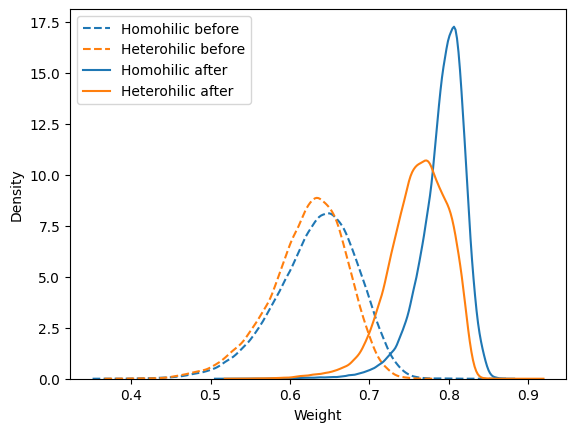

In [11]:
analyse_edge_weights(result_dict[0])

In [12]:
df_lp = pd.DataFrame(result_dict)
df_lp.mean()

/tmp/ipykernel_4297/3632260853.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_lp.mean()


fold_id                 1.500000
seed                    0.000000
known_val_acc_run       0.179167
unknown_val_acc_run     0.591667
all_val_acc_run         0.295833
val_unseen_mi_run       0.162205
known_test_acc_run      0.173625
unknown_test_acc_run    0.608395
all_test_acc_run        0.381202
test_unseen_mi_run      0.116934
dtype: float64

In [13]:
result_dict = run_setup(n_runs, "closest", dataset_name, model_name)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.35it/s]


In [14]:
df_closest = pd.DataFrame(result_dict)
df_closest.mean()

/tmp/ipykernel_4297/3286121197.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_closest.mean()


fold_id                 1.500000
seed                    0.000000
known_val_acc_run       0.179167
unknown_val_acc_run     0.591667
all_val_acc_run         0.295833
val_unseen_mi_run       0.162205
known_test_acc_run      0.173625
unknown_test_acc_run    0.608395
all_test_acc_run        0.381202
test_unseen_mi_run      0.116934
dtype: float64

In [15]:
df_lp["PL"] = "lp"
df_closest["PL"] = "proto"
data = pd.concat([df_closest, df_lp], ignore_index=True)

In [16]:
data = data.rename(columns={"known_val_acc_run": "Known Acc", "unknown_val_acc_run": "Unknown Acc", "all_val_acc_run": "All acc", "val_unseen_mi_run" : "Unknown MI"})
data

,fold_id,seed,data,start_weights,end_weights,Known Acc,Unknown Acc,All acc,Unknown MI,known_test_acc_run,unknown_test_acc_run,all_test_acc_run,test_unseen_mi_run,PL
0,0,0,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...","[tensor(0.5836), tensor(0.5576), tensor(0.5548...","[tensor(0.7783), tensor(0.7761), tensor(0.7824...",0.250000,0.516667,0.183333,0.026164,0.265502,0.738488,0.345181,0.081286,proto
1,1,0,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...","[tensor(0.5843), tensor(0.5748), tensor(0.5713...","[tensor(0.6989), tensor(0.7081), tensor(0.7154...",0.341667,0.700000,0.250000,0.330840,0.218110,0.536479,0.299557,0.071179,proto
2,2,0,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...","[tensor(0.6015), tensor(0.6158), tensor(0.6085...","[tensor(0.6822), tensor(0.6809), tensor(0.6814...",0.075000,0.600000,0.422222,0.195061,0.100131,0.678883,0.486394,0.167280,proto
3,3,0,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...","[tensor(0.5449), tensor(0.5228), tensor(0.5177...","[tensor(0.6940), tensor(0.6958), tensor(0.7031...",0.050000,0.550000,0.327778,0.096755,0.110756,0.479730,0.393676,0.147992,proto
4,0,0,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...","[tensor(0.5836), tensor(0.5576), tensor(0.5548...","[tensor(0.7783), tensor(0.7761), tensor(0.7824...",0.250000,0.516667,0.183333,0.026164,0.265502,0.738488,0.345181,0.081286,lp
5,1,0,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...","[tensor(0.5843), tensor(0.5748), tensor(0.5713...","[tensor(0.6989), tensor(0.7081), tensor(0.7154...",0.341667,0.700000,0.250000,0.330840,0.218110,0.536479,0.299557,0.071179,lp
6,2,0,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...","[tensor(0.6015), tensor(0.6158), tensor(0.6085...","[tensor(0.6822), tensor(0.6809), tensor(0.6814...",0.075000,0.600000,0.422222,0.195061,0.100131,0.678883,0.486394,0.167280,lp
7,3,0,"[(x, [tensor([0., 0., 0., 0., 0., 0., 0., 0., ...","[tensor(0.5449), tensor(0.5228), tensor(0.5177...","[tensor(0.6940), tensor(0.6958), tensor(0.7031...",0.050000,0.550000,0.327778,0.096755,0.110756,0.479730,0.393676,0.147992,lp


In [17]:
df2 = pd.melt(data, id_vars=['PL'], value_vars=['Known Acc', 'Unknown Acc', 'All acc', 'Unknown MI'])

In [18]:
df2.head(20)

,PL,variable,value
0,proto,Known Acc,0.250000
1,proto,Known Acc,0.341667
2,proto,Known Acc,0.075000
3,proto,Known Acc,0.050000
4,lp,Known Acc,0.250000
5,lp,Known Acc,0.341667
6,lp,Known Acc,0.075000
7,lp,Known Acc,0.050000
8,proto,Unknown Acc,0.516667
9,proto,Unknown Acc,0.700000


POWN, mean, arxiv, all acc: 0.485318
POWN, param, arxiv, all acc: 0.675016
GCN , arxiv, all acc: 0.485318

In [ ]:
# Create a Seaborn paired box plot
sns.boxplot(data=df2, x='variable', y='value', hue='PL', whis=[0, 100])
plt.xlabel("Pseudo Label Method")
plt.ylabel("Metrics")
plt.title("Paired Box Plot to Compare LP versus Closest Proto")
plt.legend(title='Lists')
plt.tight_layout()
#plt.ylim((0.5, 0.7))
# Show the plot
plt.show()